In [1]:
import sys
sys.path.insert(0, '/das/work/p17/p17983/')

In [2]:
%matplotlib nbagg
import numpy as np
import json
import os
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import errfunc_sigma, errfunc_fwhm
from built_functions import *

[INFO][corrections] Numba not available, reverting to Numpy


Set up the filters.  "numstds" is the number of standard deviations to take from the median.

Plot some diagnostics

In [3]:
def get_XAS_timescans(scan_name, DIR, DIR_json, numstds, minIzero, lin_filter):


    json_file = DIR_json + scan_name + "_scan_info.json"
    print (json_file)

    with open(json_file) as file:
        data = json.load(file)
    numFiles = len(data['scan_files'])

    delay_mm = np.empty(0)
    iZero = np.empty(0)
    iZero = np.empty(0)
    
    err_DataFluo_pump_total = np.empty(0)
    err_DataFluo_unpump_total = np.empty(0)

    
    DataFluo_pump_norm_total = np.empty(0)
    DataFluo_unpump_norm_total = np.empty(0)

    IzeroFEL_pump_original_total = np.empty(0)
    IzeroFEL_unpump_original_total = np.empty(0)    
    DataFluo_pump_original_total = np.empty(0)
    DataFluo_unpump_original_total = np.empty(0)
    
    IzeroFEL_pump_total = np.empty(0)
    IzeroFEL_unpump_total = np.empty(0)
    DataFluo_pump_total = np.empty(0)
    DataFluo_unpump_total = np.empty(0)
    
    
    diff_s2s = np.empty(0)

    
    for i in range(0,numFiles):
        filename = str(data['scan_files'][i][0])
        filename = DIR + os.path.basename(filename)
        exists = os.path.isfile(filename)
        if not exists:
            print("No such file")
        elif exists: #Do we need this 39?
            (DataFluo_pump, DataFluo_unpump, IzeroFEL_pump, IzeroFEL_unpump, delay, _, _, _) = \
                load_PumpProbe_events(filename, channel_delay_SH)
                
#             print('\n\n\n'+scan_name)
#             print('shape of pumped data')
#             print(DataFluo_pump.shape)
#             print('shape of unpumped data')
#             print(DataFluo_unpump.shape)
                
            IzeroFEL_pump_original = IzeroFEL_pump.copy()
            IzeroFEL_unpump_original = IzeroFEL_unpump.copy()

            IzeroFEL_pump_original_total = np.append(IzeroFEL_pump_original_total, IzeroFEL_pump_original)
            IzeroFEL_unpump_original_total = np.append(IzeroFEL_unpump_original_total, IzeroFEL_unpump_original)

            DataFluo_pump_original_total = np.append(DataFluo_pump_original_total, DataFluo_pump)
            DataFluo_unpump_original_total = np.append(DataFluo_unpump_original_total, DataFluo_unpump)
            
            
            
            
            ##below is trying shot2shot subraction 
            DataFluo_pump_norm_ = DataFluo_pump/IzeroFEL_pump #need to do this ahead of conditions to set the difference s2s value
            DataFluo_unpump_norm_ = DataFluo_unpump/IzeroFEL_unpump
            diff_ = DataFluo_pump_norm_-DataFluo_unpump_norm_
            
            # filter
            IzeroFEL_pump, IzeroFEL_unpump, DataFluo_pump, DataFluo_unpump, condFinalPump, condFinalUnPump\
                =filterData(IzeroFEL_pump, IzeroFEL_unpump, DataFluo_pump, DataFluo_unpump, numstds, minIzero, lin_filter)    

            DataFluo_pump_norm = DataFluo_pump/IzeroFEL_pump
            DataFluo_unpump_norm = DataFluo_unpump/IzeroFEL_unpump
            

#             print('i = ',i)
            
            cond_diff_s2s = condFinalPump & condFinalUnPump
#             print('\nsize of diff_s2s')
#             print(diff_.shape)
#             print('\nsize of s2s condition')
#             print(cond_diff_s2s.shape)
            
            diff_ = diff_[cond_diff_s2s]
#             print('\nmean of diff_')
#             print(diff_.mean())
            diff_s2s = np.append(diff_s2s,diff_.mean())
            
            
            

            DataFluo_pump_norm_total = np.append(DataFluo_pump_norm_total, DataFluo_pump_norm.mean())
            DataFluo_unpump_norm_total = np.append(DataFluo_unpump_norm_total, DataFluo_unpump_norm.mean())
            
            IzeroFEL_pump_total = np.append(IzeroFEL_pump_total, IzeroFEL_pump)
            IzeroFEL_unpump_total = np.append(IzeroFEL_unpump_total, IzeroFEL_unpump)

            
            err_DataFluo_pump_total = np.append(err_DataFluo_pump_total, DataFluo_pump_norm.std()/np.sqrt(DataFluo_pump_norm.size))
            err_DataFluo_unpump_total = np.append(err_DataFluo_unpump_total, DataFluo_unpump_norm.std()/np.sqrt(DataFluo_unpump_norm.size))
          
            delay = [x for x in delay if (np.abs(x) > 0)]
            delay_mm = np.append(delay_mm, np.mean(delay))
            iZero = [x for x in iZero if (np.abs(x) > 0)]
            iZero = np.append(iZero, np.mean(IzeroFEL_pump_total))    
            

#     print('diff_s2s\n')
#     print(diff_s2s)

    return iZero, delay_mm, DataFluo_unpump_norm_total, DataFluo_pump_norm_total, err_DataFluo_unpump_total, err_DataFluo_pump_total, diff_s2s
        

In [4]:
def get_XAS_average_scanlist(numstds, minIzero, folder_name, scanlist, DIR_json):
    ploton = True


    iZero_all = np.empty(0)
    delay_mm_all = np.empty(0)
    delay_mm_all_err = np.empty(0)
    DataFluo_unpump_norm_total_all = np.empty(0)
    DataFluo_pump_norm_total_all = np.empty(0)
    DataFluo_unpump_norm_total_all_err = np.empty(0)
    DataFluo_pump_norm_total_all_err = np.empty(0)
    diff_s2s_all = np.empty(0)

    for jj in range(0, len(scanlist)):
        if scanlist[jj] < 10:
            scan_name = folder_name + '00' + str(scanlist[jj])
        else:
            scan_name = folder_name + '0' + str(scanlist[jj])

        DIR = "/sf/alvra/data/p17983/raw/scan_data/" + scan_name + "/"    
        print('Opening ' + DIR + '...')

        (iZero, delay_mm, DataFluo_unpump_norm_total, DataFluo_pump_norm_total, err_DataFluo_unpump_total, err_DataFluo_pump_total, diff_s2s)\
            = get_XAS_timescans(scan_name, DIR, DIR_json, numstds, minIzero, lin_filter)

        iZero_all = np.append(iZero_all, iZero)
        delay_mm_all = np.append(delay_mm_all, delay_mm)
        DataFluo_unpump_norm_total_all = np.append(DataFluo_unpump_norm_total_all, DataFluo_unpump_norm_total)
        DataFluo_pump_norm_total_all = np.append(DataFluo_pump_norm_total_all, DataFluo_pump_norm_total)
        DataFluo_unpump_norm_total_all_err = np.append(DataFluo_unpump_norm_total_all_err, np.square(err_DataFluo_unpump_total))
        DataFluo_pump_norm_total_all_err = np.append(DataFluo_pump_norm_total_all_err, np.square(err_DataFluo_pump_total))


        DataFluo_unpump_norm_total_all_err = 1/np.sqrt(len(scanlist))*np.sqrt(DataFluo_unpump_norm_total_all_err)
        DataFluo_pump_norm_total_all_err = 1/np.sqrt(len(scanlist))*np.sqrt(DataFluo_pump_norm_total_all_err)                                             

        n1 = delay_mm_all.shape[0]
        n2 = len(scanlist)

        delay_mm_all = np.reshape(delay_mm_all, (n2, int(n1/n2)))
        DataFluo_unpump_norm_total_all = np.reshape(DataFluo_unpump_norm_total_all, (n2, int(n1/n2)))
        DataFluo_pump_norm_total_all = np.reshape(DataFluo_pump_norm_total_all, (n2, int(n1/n2)))

        delay_mm_all = np.mean(delay_mm_all, axis=0)
        DataFluo_unpump_norm_total_all = np.mean(DataFluo_unpump_norm_total_all, axis=0)
        DataFluo_pump_norm_total_all = np.mean(DataFluo_pump_norm_total_all, axis=0)
        DataFluo_unpump_norm_total_all_err = np.std(DataFluo_unpump_norm_total_all, axis=0)
        DataFluo_pump_norm_total_all_err = np.std(DataFluo_pump_norm_total_all, axis=0)

        normaliz = np.mean(DataFluo_unpump_norm_total_all)

        diff = (DataFluo_pump_norm_total_all - DataFluo_unpump_norm_total_all)/normaliz
        diff_err = np.sqrt(np.square(DataFluo_pump_norm_total_all_err) + np.square(DataFluo_unpump_norm_total_all_err))\
            /normaliz

        print('Normalization = ' + str(normaliz))
        print('jj = ',jj)
        
        
        diff_s2s_all = np.append(diff_s2s_all, diff_s2s.mean())

        # convert delays to ps
        #time_zero_mm = 160
        time_zero_mm = 156.3276 #RuDimerACN_timescan_*
        delay_ps = np.array(1e12*(delay_mm_all - time_zero_mm)*2*1e-3/(3e8))

        p = DataFluo_pump_norm_total_all
        u = DataFluo_unpump_norm_total_all
        p_err = DataFluo_pump_norm_total_all_err
        u_err = DataFluo_unpump_norm_total_all_err

    return scan_name, delay_ps, diff, diff_err, p, p_err, u, u_err, iZero_all, diff_s2s

In [6]:
ploton = True

lin_filter = 0.1
numstds = 2
minIzero = 0.015

folder_name = "RuDimerACN_timescan_"

scanlist_1 = [12]

DIR_json = "/sf/alvra/data/p17983/res/scan_info/"
scan_name_1, delay_ps_1, diff_1, diff_err_1, p_1, p_err_1, u_1, u_err_1, iZero_all_01, diff_s2s_01= \
    get_XAS_average_scanlist(numstds, minIzero, folder_name, scanlist_1, DIR_json)

    
scanlist_2 = [24]

DIR_json = "/sf/alvra/data/p17983/res/scan_info/"
scan_name_2, delay_ps_2, diff_2, diff_err_2, p_2, p_err_2, u_2, u_err_2, iZero_all_02, diff_s2s_02 = \
    get_XAS_average_scanlist(numstds, minIzero, folder_name, scanlist_2, DIR_json)
    

Opening /sf/alvra/data/p17983/raw/scan_data/RuDimerACN_timescan_012/...
/sf/alvra/data/p17983/res/scan_info/RuDimerACN_timescan_012_scan_info.json
Normalization = 4.564641259475111
jj =  0
Opening /sf/alvra/data/p17983/raw/scan_data/RuDimerACN_timescan_024/...
/sf/alvra/data/p17983/res/scan_info/RuDimerACN_timescan_024_scan_info.json
Normalization = 3.943088835269452
jj =  0


<IPython.core.display.Javascript object>


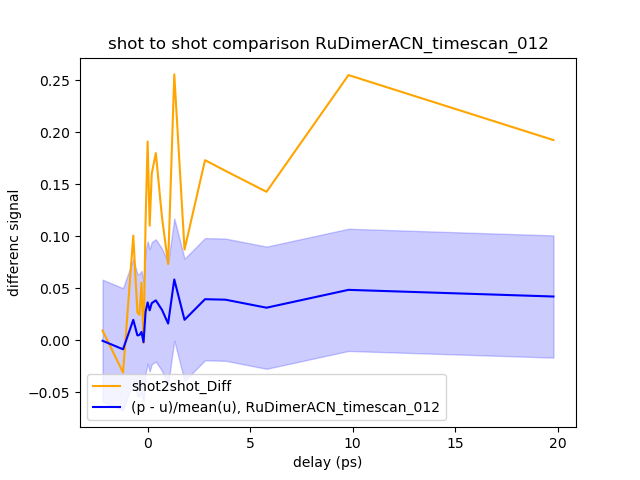

<IPython.core.display.Javascript object>


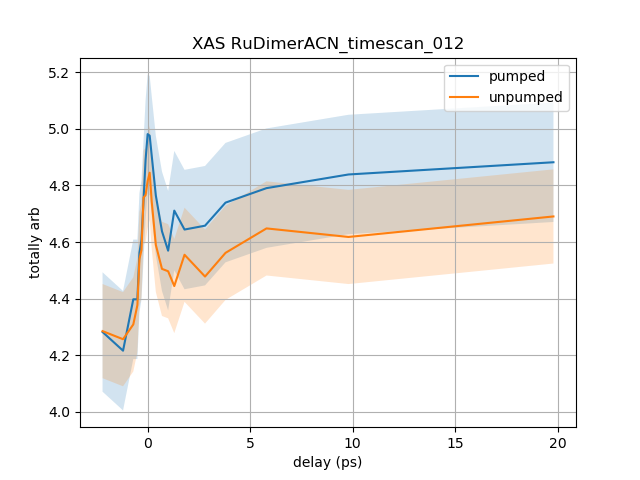

<IPython.core.display.Javascript object>


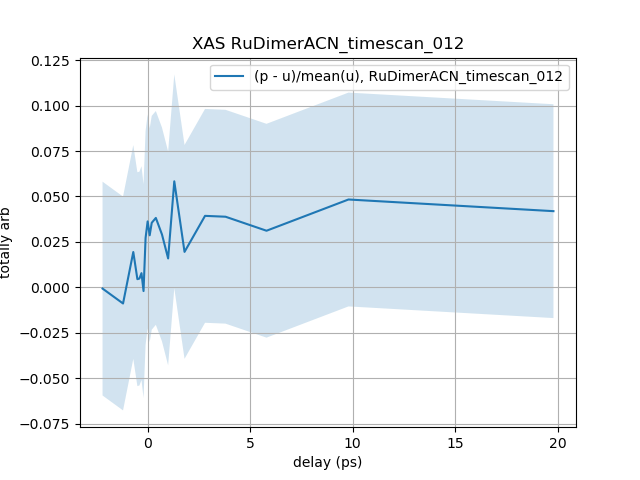

In [7]:
# plt.figure()
# plt.plot(delay_ps_1, iZero_all_01, label='IZero_01')

plt.figure()
plt.plot(delay_ps_1,diff_s2s_01, label ='shot2shot_Diff', color = 'orange')
plt.plot(delay_ps_1, diff_1, label='(p - u)/mean(u), ' + scan_name_1, color = 'blue')
plt.fill_between(delay_ps_1, diff_1 - diff_err_1, diff_1 + diff_err_1, alpha = 0.2, color = 'blue')

plt.title('shot to shot comparison ' + scan_name_1)
plt.ylabel('differenc signal')
plt.xlabel('delay (ps)')
plt.legend()



plt.figure()
plt.plot(delay_ps_1, p_1, label='pumped')
plt.fill_between(delay_ps_1, p_1 - p_err_1, p_1 + p_err_1, alpha=0.2) 
plt.plot(delay_ps_1, u_1, label='unpumped') 
plt.fill_between(delay_ps_1, u_1 - u_err_1, u_1 + u_err_1, alpha = 0.2)
plt.legend()
plt.title('XAS ' + scan_name_1)
plt.ylabel('totally arb')
plt.xlabel('delay (ps)')
plt.grid()

plt.figure()
plt.plot(delay_ps_1, diff_1, label='(p - u)/mean(u), ' + scan_name_1)
plt.fill_between(delay_ps_1, diff_1 - diff_err_1, diff_1 + diff_err_1, alpha = 0.2)
plt.legend()
plt.title('XAS ' + scan_name_1)
plt.ylabel('totally arb')
plt.xlabel('delay (ps)')
plt.grid()


<IPython.core.display.Javascript object>


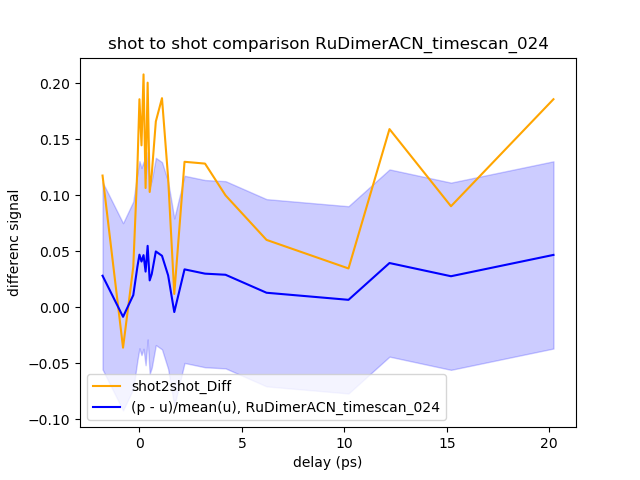

<IPython.core.display.Javascript object>


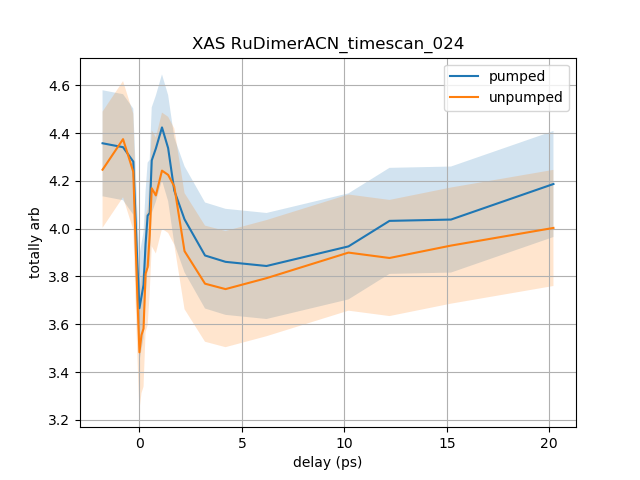

<IPython.core.display.Javascript object>


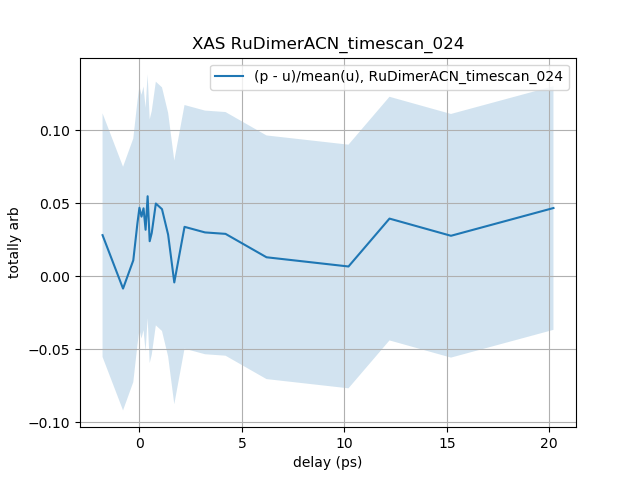

In [8]:
plt.figure()
plt.plot(delay_ps_2,diff_s2s_02, label ='shot2shot_Diff', color = 'orange')
plt.plot(delay_ps_2, diff_2, label='(p - u)/mean(u), ' + scan_name_2, color = 'blue')
plt.fill_between(delay_ps_2, diff_2 - diff_err_2, diff_2 + diff_err_2, alpha = 0.2, color = 'blue')
plt.title('shot to shot comparison ' + scan_name_2)
plt.ylabel('differenc signal')
plt.xlabel('delay (ps)')
plt.legend()



plt.figure()
plt.plot(delay_ps_2, p_2, label='pumped')
plt.fill_between(delay_ps_2, p_2 - p_err_2, p_2 + p_err_2, alpha=0.2) 
plt.plot(delay_ps_2, u_2, label='unpumped') 
plt.fill_between(delay_ps_2, u_2 - u_err_2, u_2 + u_err_2, alpha = 0.2)
plt.legend()
plt.title('XAS ' + scan_name_2)
plt.ylabel('totally arb')
plt.xlabel('delay (ps)')
plt.grid()

plt.figure()
plt.plot(delay_ps_2, diff_2, label='(p - u)/mean(u), ' + scan_name_2)
plt.fill_between(delay_ps_2, diff_2 - diff_err_2, diff_2 + diff_err_2, alpha = 0.2)
plt.legend()
plt.title('XAS ' + scan_name_2)
plt.ylabel('totally arb')
plt.xlabel('delay (ps)')
plt.grid()